In [43]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import time
import os
import copy
import cv2
import random

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [45]:
def train_model(model, criterion, optimizer, data_loaders, batch_size, num_epochs=30):
  start_time = time.time()

  train_acc_history = []
  val_acc_history = []

  best_model_over_epochs = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Train and validate over each epoch
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      batch_loss = 0.0
      batch_correct_preds = 0

      # Iterate over data
      for inputs, labels in tqdm(data_loaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)
          
          # Backward + Optimize only in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        batch_loss += loss.item() * inputs.size(0)
        batch_correct_preds += torch.sum(preds == labels.data)
      
      epoch_loss = batch_loss / len(data_loaders[phase].dataset)
      epoch_acc = batch_correct_preds.double() / len(data_loaders[phase].dataset)

      print('-' * 50)
      print('{} Loss: {:.4f}  Acc: {:.4f}\n\n'.format(phase, epoch_loss, epoch_acc))

      # Deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_over_epochs = copy.deepcopy(model.state_dict())
      
      if phase == 'val':
        val_acc_history.append(epoch_acc)
      else:
        train_acc_history.append(epoch_acc)

  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                      time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # Load best model weights
  model.load_state_dict(best_model_over_epochs)

  return model, train_acc_history, val_acc_history

In [46]:
def visualize_acc_hist(train_acc_history, val_acc_history):
  train_hist = [h.cpu().numpy() for h in train_acc_history]
  val_hist = [h.cpu().numpy() for h in val_acc_history]

  print('Training accuracy', np.around(np.array(train_hist), 3).reshape(len(train_hist),))
  print('Validation accuracy', np.around(np.array(val_hist), 3).reshape(len(val_hist),))

  plt.figure(figsize=(15, 9))
  plt.title("Accuracy over Number of Training Epochs", fontsize=15)
  plt.xlabel("Training Epochs", fontsize=14)
  plt.ylabel("Accuracy", fontsize=14)

  plt.plot(range(1, num_epochs+1), train_hist, label="Training", marker = 'o')
  plt.plot(range(1, num_epochs+1), val_hist, label="Validation", marker = 'o')

  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend(loc='lower left', fontsize=13)
  plt.show()

In [47]:
def show_statistics(y_test, y_pred, classNames):
  print("\n**** Classification Report ****")
  print(classification_report(y_test, y_pred, target_names=classNames))
  
def plot_confusion_matrix(y_test, y_pred, classNames):
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_pred)

    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] / np.sum(cm[x,:])

    plt.figure(figsize=(15,15))
    sns.set(font_scale=1.0)
    sns.heatmap(con, annot=True, fmt='.2', cmap='Blues',
                xticklabels=classNames, yticklabels=classNames)
    plt.show()

In [48]:
batch_size = 32
input_size = 224

data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(input_size),
                                 transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])
                                ]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(input_size),
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                               ])
}

train_set = torchvision.datasets.FashionMNIST("./data",
                                              download=True,
                                              transform=data_transforms['train'])

val_set = torchvision.datasets.FashionMNIST("./data",
                                            download=True,
                                            train=False,
                                            transform=data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

data_loaders = {'train': train_loader,
                'val': val_loader}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [49]:
num_epochs = 20
num_classes = len(train_set.classes)
feature_extract = True

In [50]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

# Set all model parameters to not update
if feature_extract:
  for param in model.parameters():
    param.requires_grad = False

# Reinitialize layer’s parameters
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [51]:
# Send the model to GPU
model = model.to(device)

In [52]:
'''
Gather the parameters to be optimized/updated in this run. If we are
finetuning we will be updating all parameters. However, if we are
doing feature extract method, we will only update the parameters
that we will initialize, i.e. the parameters with requires_grad
is True
'''

params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t",name)
else:
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [53]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, train_history, val_history = train_model(model, criterion, optimizer, data_loaders, batch_size, num_epochs)

Epoch 0/19


  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1875/1875 [07:56<00:00,  3.94it/s]


--------------------------------------------------
train Loss: 0.6910  Acc: 0.7806




100%|██████████| 313/313 [01:15<00:00,  4.12it/s]


--------------------------------------------------
val Loss: 0.5049  Acc: 0.8231


Epoch 1/19


100%|██████████| 1875/1875 [07:55<00:00,  3.95it/s]


--------------------------------------------------
train Loss: 0.5009  Acc: 0.8268




100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


--------------------------------------------------
val Loss: 0.4599  Acc: 0.8377


Epoch 2/19


100%|██████████| 1875/1875 [07:54<00:00,  3.95it/s]


--------------------------------------------------
train Loss: 0.4653  Acc: 0.8377




100%|██████████| 313/313 [01:15<00:00,  4.12it/s]


--------------------------------------------------
val Loss: 0.4439  Acc: 0.8420


Epoch 3/19


100%|██████████| 1875/1875 [07:55<00:00,  3.95it/s]


--------------------------------------------------
train Loss: 0.4497  Acc: 0.8414




100%|██████████| 313/313 [01:16<00:00,  4.11it/s]


--------------------------------------------------
val Loss: 0.4353  Acc: 0.8418


Epoch 4/19


100%|██████████| 1875/1875 [07:54<00:00,  3.95it/s]


--------------------------------------------------
train Loss: 0.4396  Acc: 0.8447




100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


--------------------------------------------------
val Loss: 0.4223  Acc: 0.8488


Epoch 5/19


100%|██████████| 1875/1875 [07:54<00:00,  3.95it/s]


--------------------------------------------------
train Loss: 0.4298  Acc: 0.8471




100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


--------------------------------------------------
val Loss: 0.4281  Acc: 0.8487


Epoch 6/19


100%|██████████| 1875/1875 [07:53<00:00,  3.96it/s]


--------------------------------------------------
train Loss: 0.4251  Acc: 0.8491




100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


--------------------------------------------------
val Loss: 0.4194  Acc: 0.8495


Epoch 7/19


100%|██████████| 1875/1875 [07:51<00:00,  3.98it/s]


--------------------------------------------------
train Loss: 0.4197  Acc: 0.8498




100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


--------------------------------------------------
val Loss: 0.4102  Acc: 0.8542


Epoch 8/19


100%|██████████| 1875/1875 [07:51<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.4162  Acc: 0.8522




100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


--------------------------------------------------
val Loss: 0.4132  Acc: 0.8527


Epoch 9/19


100%|██████████| 1875/1875 [07:53<00:00,  3.96it/s]


--------------------------------------------------
train Loss: 0.4130  Acc: 0.8536




100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


--------------------------------------------------
val Loss: 0.4172  Acc: 0.8475


Epoch 10/19


100%|██████████| 1875/1875 [07:52<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.4101  Acc: 0.8540




100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


--------------------------------------------------
val Loss: 0.4183  Acc: 0.8503


Epoch 11/19


100%|██████████| 1875/1875 [07:53<00:00,  3.96it/s]


--------------------------------------------------
train Loss: 0.4069  Acc: 0.8555




100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


--------------------------------------------------
val Loss: 0.4086  Acc: 0.8522


Epoch 12/19


100%|██████████| 1875/1875 [07:51<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.4050  Acc: 0.8555




100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


--------------------------------------------------
val Loss: 0.4135  Acc: 0.8524


Epoch 13/19


100%|██████████| 1875/1875 [07:51<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.4039  Acc: 0.8547




100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


--------------------------------------------------
val Loss: 0.4115  Acc: 0.8498


Epoch 14/19


100%|██████████| 1875/1875 [07:51<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.4032  Acc: 0.8547




100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


--------------------------------------------------
val Loss: 0.4086  Acc: 0.8529


Epoch 15/19


100%|██████████| 1875/1875 [07:51<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.4010  Acc: 0.8564




100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


--------------------------------------------------
val Loss: 0.4209  Acc: 0.8483


Epoch 16/19


100%|██████████| 1875/1875 [07:52<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.3987  Acc: 0.8575




100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


--------------------------------------------------
val Loss: 0.4026  Acc: 0.8569


Epoch 17/19


100%|██████████| 1875/1875 [07:51<00:00,  3.98it/s]


--------------------------------------------------
train Loss: 0.4014  Acc: 0.8563




100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


--------------------------------------------------
val Loss: 0.4093  Acc: 0.8542


Epoch 18/19


100%|██████████| 1875/1875 [07:52<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.3986  Acc: 0.8577




100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


--------------------------------------------------
val Loss: 0.4043  Acc: 0.8566


Epoch 19/19


100%|██████████| 1875/1875 [07:52<00:00,  3.97it/s]


--------------------------------------------------
train Loss: 0.3958  Acc: 0.8574




100%|██████████| 313/313 [01:15<00:00,  4.14it/s]

--------------------------------------------------
val Loss: 0.4124  Acc: 0.8537


Training complete in 182m 56s
Best val Acc: 0.856900


Training accuracy [0.781 0.827 0.838 0.841 0.845 0.847 0.849 0.85  0.852 0.854 0.854 0.856
 0.855 0.855 0.855 0.856 0.857 0.856 0.858 0.857]
Validation accuracy [0.823 0.838 0.842 0.842 0.849 0.849 0.85  0.854 0.853 0.848 0.85  0.852
 0.852 0.85  0.853 0.848 0.857 0.854 0.857 0.854]


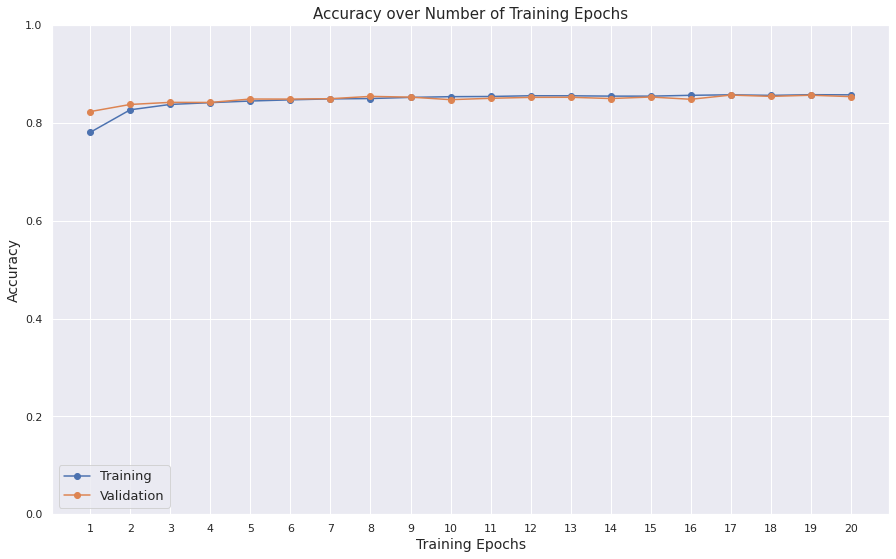

In [54]:
visualize_acc_hist(train_history, val_history)

In [55]:
test_labels = []
predict_labels = []

for inputs, labels in tqdm(data_loaders['val']):
  test_labels.extend(list(labels.detach().cpu().numpy()))

  inputs = inputs.to(device)
  labels = labels.to(device)

  predicted = model(inputs)
  _, preds = torch.max(predicted, 1)
  predict_labels.extend(list(preds.detach().cpu().numpy()))

print(test_labels)
print(predict_labels)

  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 313/313 [01:15<00:00,  4.15it/s]

[9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9, 1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8, 0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6, 9, 2, 6, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 3, 0, 6, 6, 7, 5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8, 8, 3, 3, 6, 8, 0, 0, 2, 9, 7, 7, 1, 3, 6, 4, 2, 4, 9, 1, 6, 4, 8, 2, 6, 5, 4, 6, 7, 7, 7, 3, 3, 7, 0, 

In [56]:
show_statistics(test_labels, predict_labels, list(train_set.classes))


**** Classification Report ****
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.83      0.82      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.76      0.81      0.78      1000
       Dress       0.84      0.86      0.85      1000
        Coat       0.75      0.77      0.76      1000
      Sandal       0.96      0.93      0.95      1000
       Shirt       0.65      0.57      0.61      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.96      0.95      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [58]:
batch = next(iter(val_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, Coat, Shirt, Sandal, Sneaker, 
Predicted:  Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, Pullover, Shirt, Sandal, Sneaker, 

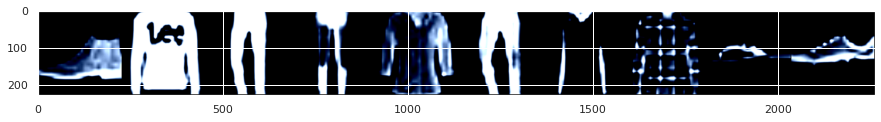

In [59]:
grid = torchvision.utils.make_grid(images[:10], nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("Labels: ", end=" ")
for i, label in enumerate(labels[:15]):
  print(val_set.classes[label], end=", ")

print("\nPredicted: ", end=" ")
for i, label in enumerate(predict_labels[:15]):
  print(val_set.classes[label], end=", ")

In [60]:
class SiameseFashionMNIST(torchvision.datasets.FashionMNIST):
  def __init__(self, *args, **kwargs):
    super(SiameseFashionMNIST, self).__init__(*args, **kwargs)
    if kwargs["train"] is True:
      self.data, self.labels = self.train_data, self.train_labels
    else:
      self.data, self.labels = self.test_data, self.test_labels

  def __getitem__(self, idx):
    x1, t1 = self.data[idx], self.labels[idx]

    is_diff = random.randint(0, 1)
    while True:
      idx2 = random.randint(0, len(self)-1)
      x2, t2 = self.data[idx2], self.labels[idx2]
      if is_diff and t1 != t2:
        break
      if not is_diff and t1 == t2:
        break

    x1, x2 = Image.fromarray(x1.numpy()), Image.fromarray(x2.numpy())
    if self.transform is not None:
      x1, x2 = self.transform(x1), self.transform(x2)
    return x1, x2, int(is_diff), t1


siamese_data_transforms = transforms.Compose([transforms.ToTensor()])

siamese_train_loader = torch.utils.data.DataLoader(
    SiameseFashionMNIST("./data",
                        download=True,
                        train=True,
                        transform=siamese_data_transforms),
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

siamese_test_loader = torch.utils.data.DataLoader(
    SiameseFashionMNIST("./data",
                        download=True,
                        train=False,
                        transform=siamese_data_transforms),
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.

In [61]:
class Siamese(nn.Module):
  def __init__(self):
    super(Siamese, self).__init__()
    self.c1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.c2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.c3 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
    self.bn3 = nn.BatchNorm2d(128)

    self.fc4 = nn.Linear(128, 64)
    self.bn4 = nn.BatchNorm1d(64)
    self.fc5 = nn.Linear(64, 2)

  def forward(self, x):
    h = F.max_pool2d(self.bn1(self.c1(x)), 2)
    h = F.max_pool2d(self.bn2(self.c2(h)), 2)
    h = F.avg_pool2d(self.bn3(self.c3(h)), 5)

    h = self.bn4(self.fc4(h.view(h.size(0), -1)))
    return self.fc5(h)


def contractive_loss(o1, o2, y):
  g, margin = F.pairwise_distance(o1, o2), 5.0
  loss = (1 - y) * (g ** 2) + y * (torch.clamp(margin - g, min=0) ** 2)
  return torch.mean(loss)

In [62]:
siamese_model = Siamese().cuda()

opt = optim.SGD(siamese_model.parameters(), lr=0.01, momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(opt, [5, 10], 0.1)
cudnn.benckmark = True

best_siamese_model_over_epochs = copy.deepcopy(siamese_model.state_dict())
best_loss = np.Inf

for e in range(20):
  scheduler.step()
  model.train()
  train_loss, train_n = 0, 0
  for x1, x2, y, label in tqdm(siamese_train_loader, total=len(siamese_train_loader), leave=False):
  # for x1, x2, y in siamese_train_loader:
    x1, x2 = Variable(x1.cuda()), Variable(x2.cuda())
    y = Variable(y.float().cuda()).view(y.size(0), 1)

    o1, o2 = siamese_model(x1), siamese_model(x2)
    loss = contractive_loss(o1, o2, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    train_loss = loss.detach().cpu().numpy() * y.size(0)
    train_n += y.size(0)

  siamese_model.eval()
  test_loss, test_n = 0, 0
  for x1, x2, y, label in tqdm(siamese_test_loader, total=len(siamese_test_loader), leave=False):
    x1, x2 = Variable(x1.cuda()), Variable(x2.cuda())
    y = Variable(y.float().cuda()).view(y.size(0), 1)

    o1, o2 = siamese_model(x1), siamese_model(x2)
    loss = contractive_loss(o1, o2, y)
    test_loss = loss.detach().cpu().numpy() * y.size(0)
    test_n += y.size(0)
  
  if best_loss > test_loss:
    best_loss = test_loss
    best_siamese_model_over_epochs = copy.deepcopy(siamese_model.state_dict())
    
  print("\t".join(["Epoch", "TrainLoss", "TestLoss"]))
  print("{}\t{:.6f}\t{:.6f}".format(e, train_loss / train_n, test_loss / test_n))

# Load best model weights
siamese_model.load_state_dict(best_siamese_model_over_epochs)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential sl

Epoch	TrainLoss	TestLoss
0	0.003863	0.010414


Epoch	TrainLoss	TestLoss
1	0.003952	0.010806


Epoch	TrainLoss	TestLoss
2	0.004206	0.012213


Epoch	TrainLoss	TestLoss
3	0.004234	0.012017


Epoch	TrainLoss	TestLoss
4	0.003755	0.011225


Epoch	TrainLoss	TestLoss
5	0.003900	0.011550


Epoch	TrainLoss	TestLoss
6	0.003895	0.011016


Epoch	TrainLoss	TestLoss
7	0.003940	0.013421


Epoch	TrainLoss	TestLoss
8	0.004359	0.010137


Epoch	TrainLoss	TestLoss
9	0.003920	0.010408


Epoch	TrainLoss	TestLoss
10	0.003983	0.013095


Epoch	TrainLoss	TestLoss
11	0.003849	0.013361


Epoch	TrainLoss	TestLoss
12	0.003796	0.013498


Epoch	TrainLoss	TestLoss
13	0.003896	0.010182


Epoch	TrainLoss	TestLoss
14	0.004099	0.009484


Epoch	TrainLoss	TestLoss
15	0.003920	0.010779


Epoch	TrainLoss	TestLoss
16	0.004230	0.010776


Epoch	TrainLoss	TestLoss
17	0.004158	0.012986


Epoch	TrainLoss	TestLoss
18	0.003989	0.011568


Epoch	TrainLoss	TestLoss
19	0.003972	0.011564


<All keys matched successfully>

In [63]:
siamese_model.eval()

inputs, embs, targets, labels = [], [], [], []
for x, x2, t, label in tqdm(siamese_test_loader, total=len(siamese_test_loader)):
# for x, x2, t in siamese_test_loader:
  x = Variable(x.cuda())
  o1 = siamese_model(x)
  inputs.extend(list(x.cpu().data.numpy()))
  embs.extend(list(o1.cpu().data.numpy()))
  targets.extend(list(t.numpy()))
  labels.extend(list(label.numpy()))

  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 313/313 [00:06<00:00, 51.64it/s]


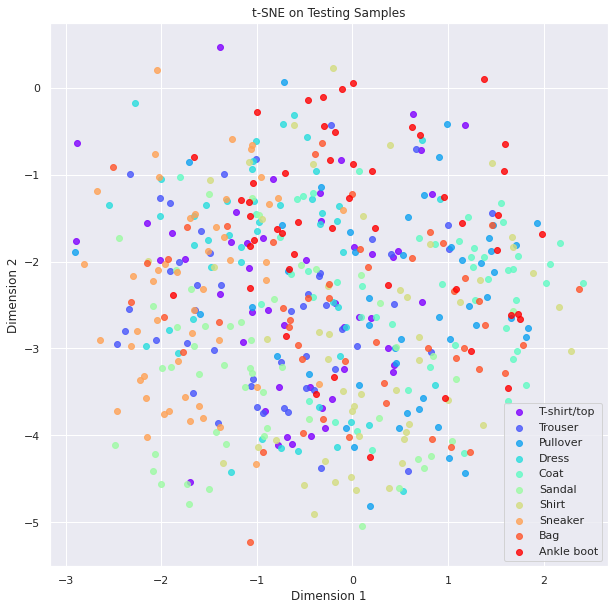

In [64]:
val_set.classes
obj_categories = val_set.classes

colors = plt.cm.rainbow(np.linspace(0, 1, len(obj_categories)))
plt.figure(figsize=(10, 10))

embs = np.array(embs)
labels = np.array(labels)

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(embs[np.where(labels == c_group), 0].flatten()[:50],
              embs[np.where(labels == c_group), 1].flatten()[:50],
              marker='o',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)